In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import sklearn.metrics as metrics
import torch
from ray import air, tune
from ray.air import session

import flippers
from flippers.models import SnorkelModel

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.notebook_utils import (
    load_wrench_dataset,
    MetricsMaker,
    datasets,
    dataset_to_metric,
)

In [6]:
Best_Configs = {}
Results = {}
Metrics = {}

In [7]:
ray.init()

2024-04-05 16:06:30,008	INFO worker.py:1743 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.10.0
Dashboard:,http://127.0.0.1:8265


In [ ]:
%%time

# Define a search space and initialize the search algorithm.
search_space = {
    "learning_rate": tune.grid_search([1e-2, 5e-3, 1e-3]),
    "num_epochs": tune.grid_search([10, 50, 100, 200]),
    "k": tune.grid_search([0, 1e-2, 1e-3]),
    "prec_init": tune.grid_search([0.3, 0.5, 0.7]),
}

for dataset in datasets:
    data, weak_labels, polarities = load_wrench_dataset(dataset)
    train, dev, test = data
    L_train, L_dev, L_test = weak_labels

    y_dev = dev["label"].values.astype(int)
    y_test = test["label"].values.astype(int)
    class_balances = list(
        dev["label"].astype(int).value_counts(normalize=True).sort_index()
    )

    del train
    del dev
    del test
    del data
    del weak_labels

    MetricsDev = MetricsMaker(L=L_dev, y_true=y_dev)

    # Wrap SnorkelModel in an objective function
    def objective(config):
        m = SnorkelModel(polarities=polarities, class_balances=class_balances)
        m.fit(L_train, **config)
        scores = MetricsDev.score(m, plots=False)  # Compute validation metrics
        scores["model"] = m
        session.report(scores)  # Report to Tune

    # Start a Tune run that maximizes metric on dev set
    tuner = tune.Tuner(
        tune.with_resources(objective, {"cpu": 8}),
        param_space=search_space,
        run_config=air.RunConfig(progress_reporter=tune.JupyterNotebookReporter()),
    )
    results = tuner.fit()

    metric = dataset_to_metric[dataset]
    best_result = results.get_best_result(metric=metric, mode="max")
    Best_Configs[dataset] = best_result.config
    Results[dataset] = results

    # m = SnorkelModel(polarities=polarities, class_balances=class_balances)
    # config = best_result.config
    # m.fit(L_train, **config)
    m = best_result.metrics["model"]

    Metrics[dataset] = MetricsMaker(L=L_test, y_true=y_test).score(m, plots=False)

In [9]:
df = pd.DataFrame(Metrics)


# Formatting function to underline entries
def underline_entries(x):
    is_metric = x.index == dataset_to_metric[x.name]
    return ["text-decoration: underline" if v else "" for v in is_metric]


# Underlines the metrics used in the wrench benchmark
df.style.apply(underline_entries).format("{:.3f}")

,imdb,yelp,youtube,sms,agnews,trec,spouse,cdr,semeval,chemprot,commercial,tennis,basketball,census
F1,0.729,0.763,0.845,0.072,nan,nan,0.512,0.714,nan,nan,0.882,0.825,0.174,0.594
Average_Precision,0.716,0.784,0.940,0.142,nan,nan,0.383,0.668,nan,nan,0.934,0.787,0.117,0.656
AUC,0.757,0.800,0.933,0.524,nan,nan,0.794,0.860,nan,nan,0.975,0.884,0.527,0.839
Accuracy,0.714,0.739,0.868,0.846,0.661,0.642,0.911,0.770,0.817,0.569,0.928,0.875,0.549,0.828
Balanced_Accuracy,0.714,0.737,0.862,0.507,0.662,0.624,0.759,0.801,0.657,0.399,0.908,0.875,0.515,0.726


In [10]:
final_result = pd.DataFrame(
    [100 * df.loc[dataset_to_metric[dataset], dataset] for dataset in df.columns],
    columns=["Flippers"],
    index=df.columns,
).T
final_result["Average"] = final_result.mean(axis=1)
final_result

,imdb,yelp,youtube,sms,agnews,trec,spouse,cdr,semeval,chemprot,commercial,tennis,basketball,census,Average
Flippers,71.4,73.9,86.8,7.2,66.1,64.2,51.2,71.4,81.7,56.9,88.2,82.5,17.4,59.4,62.735714


Results of other label models on wrench datasets : [[wrench]](https://arxiv.org/abs/2109.11377)

![wrench.png](notebook_utils/wrench.png)

In [11]:
pd.DataFrame(Best_Configs)

,imdb,yelp,youtube,sms,agnews,trec,spouse,cdr,semeval,chemprot,commercial,tennis,basketball,census
learning_rate,0.010,0.001,0.005,0.01,0.001,0.001,0.001,0.001,0.001,0.005,0.010,0.01,0.01,0.001
num_epochs,50.000,50.000,10.000,200.00,200.000,10.000,10.000,200.000,10.000,100.000,50.000,10.00,200.00,50.000
k,0.001,0.001,0.010,0.01,0.010,0.010,0.000,0.000,0.001,0.001,0.001,0.00,0.00,0.010
prec_init,0.300,0.300,0.700,0.30,0.500,0.300,0.300,0.500,0.500,0.300,0.300,0.30,0.30,0.500


# Inspect best hyperparameter value per model

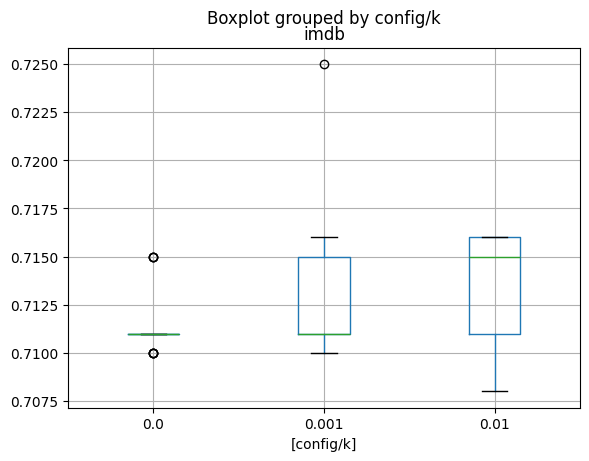

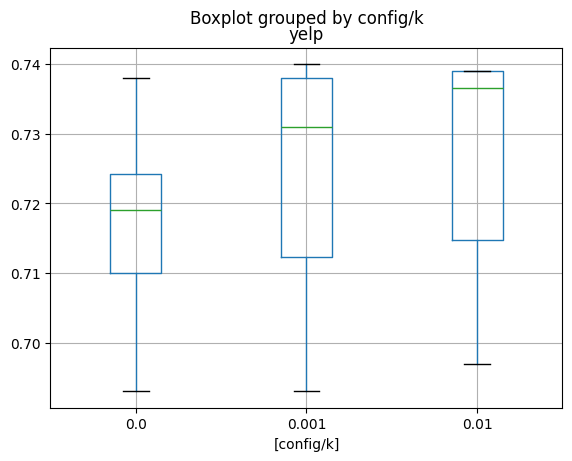

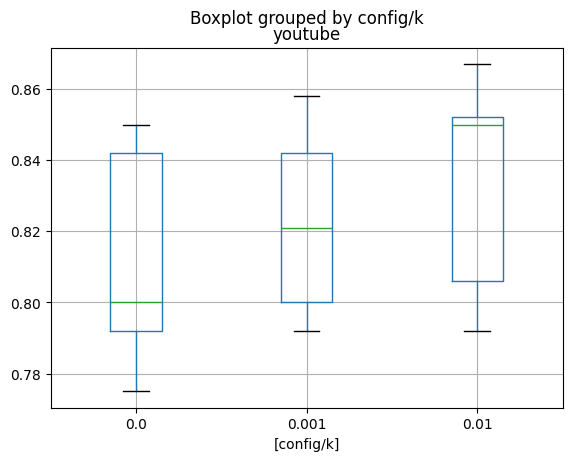

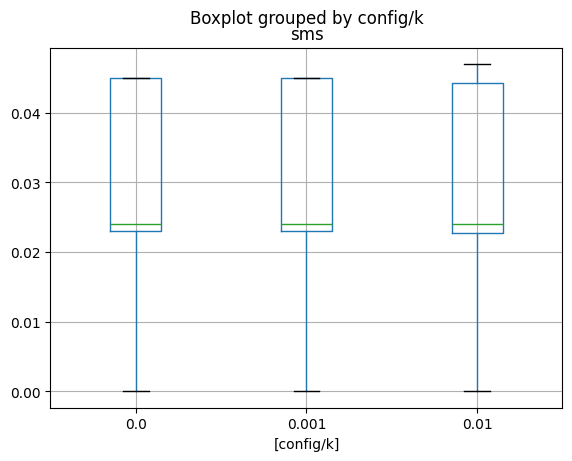

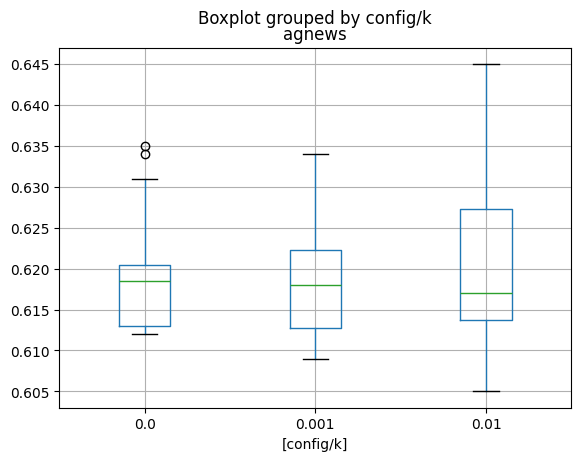

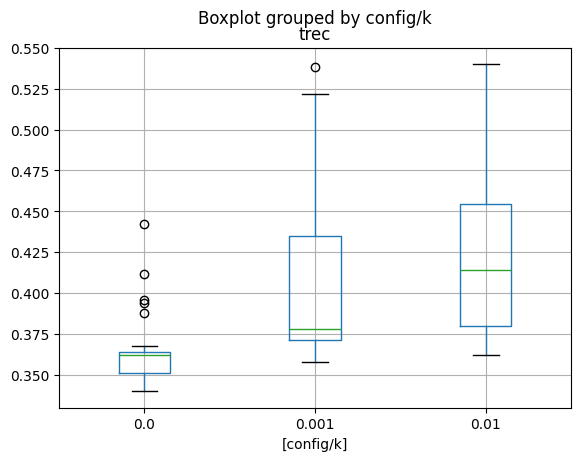

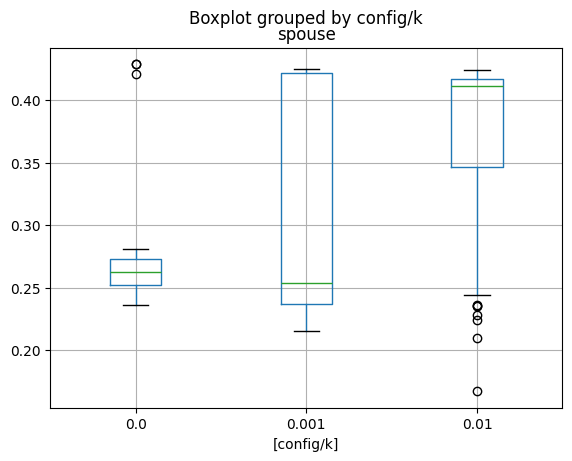

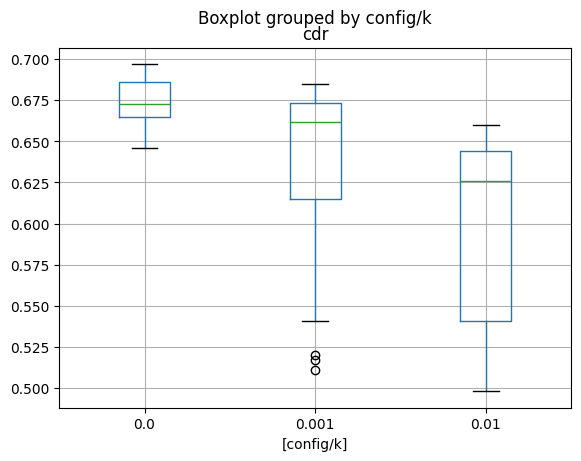

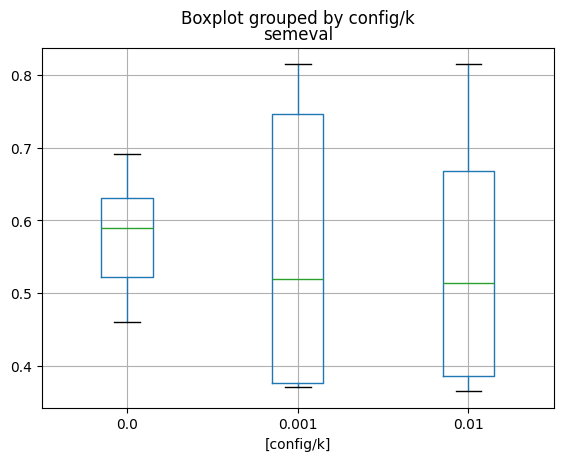

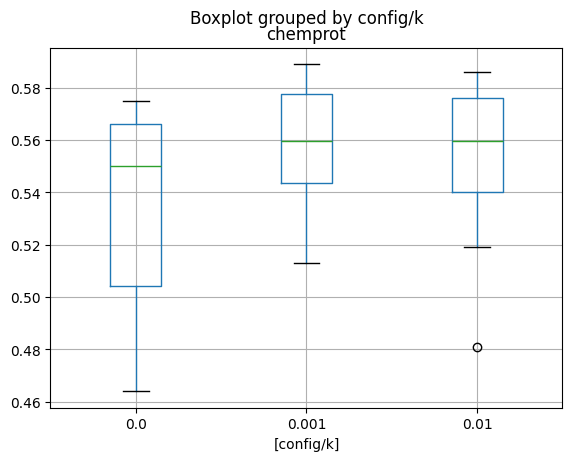

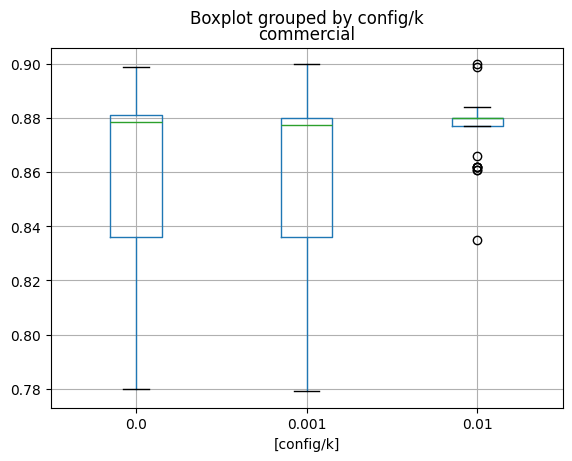

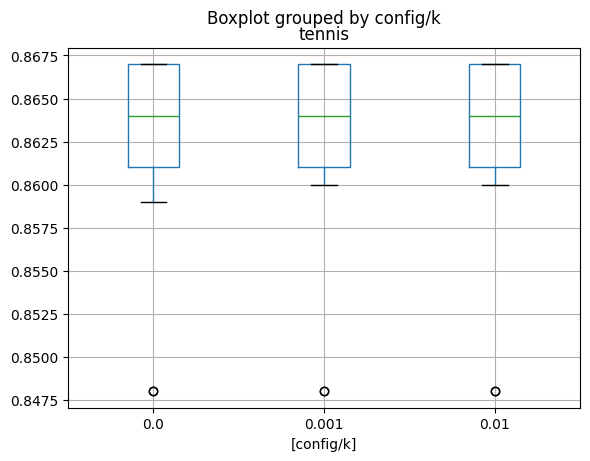

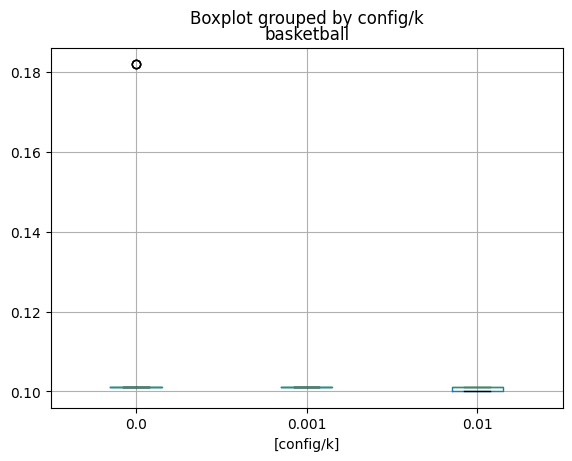

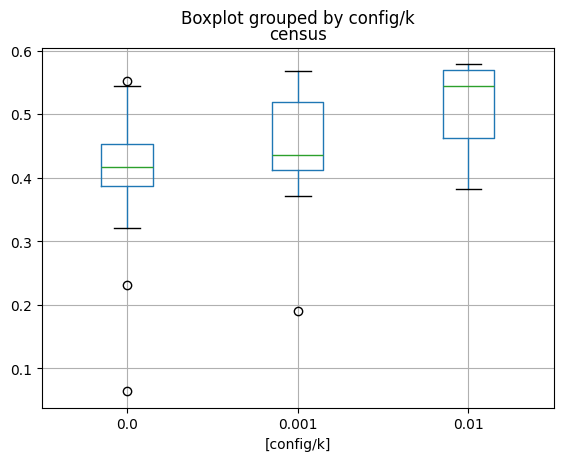

In [12]:
for dataset in datasets:
    grid = Results[dataset]
    grid = grid.get_dataframe()
    # grid = grid[grid["config/k"] == 0]
    hparam = "k"
    hparam = "config/" + hparam
    grid[[dataset_to_metric[dataset], hparam]].boxplot(by=hparam)
    plt.title(dataset)